# <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Необходимо исследовать данные и сделать выводы по полученным результатам. Подкрепить свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверить, являются ли выводы статистически значимыми.

В процессе своего анализа следует:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    *   Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    *   Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    *   Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    *   Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
3. Отметить в анализе иные интересные закономерности, если они будут найдены.
4. Продемонстрировать использование разных тестов для проверки статистической значимости сделанных выводов:
    *   тесты для количественного признака:
        *   для одной выборки;
        *   для двух выборок;
        *   для нескольких выборок;
    *   тест для категориальных признаков.

В проекте будет выбран уровень значимости $\alpha=0.05$.

## Описание исходных данных

Ответить на эти вопросы нам помогут данные:

*   work_year — Год, в котором была выплачена зарплата.
*   experience_level — Опыт работы на этой должности в течение года со следующими возможными значениями:
    *   EN — Entry-level/Junior;
    *   MI — Mid-level/Intermediate;
    *   SE — Senior-level/Expert;
    *   EX — Executive-level/Director.
*   employment_type —	Тип трудоустройства для этой роли:
    *   PT — неполный рабочий день;
    *   FT — полный рабочий день;
    *   CT — контракт;
    *   FL — фриланс.
*   job_title — Роль, в которой соискатель работал в течение года.
*   salary — Общая выплаченная валовая сумма заработной платы.
*   salary_currency — Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
*   salary_in_usd — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
*   employee_residence — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
*   remote_ratio — Общий объём работы, выполняемой удалённо. Возможные значения:
    *   0 — удалённой работы нет (менее 20 %);
    *   50 — частично удалённая работа;
    *   100 — полностью удалённая работа (более 80 %).
*   company_location — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
*   company_size — Среднее количество людей, работавших в компании в течение года:
    *   S — менее 50 сотрудников (небольшая компания);
    *   M — от 50 до 250 сотрудников (средняя компания);
    *   L — более 250 сотрудников (крупная компания).

Источник датасета: ["Data Science Job Salaries" (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries/)

## Загрузка данных

In [46]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [29]:
# загружаем датасет
data = pd.read_csv('./ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [30]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений). Проверим данные на наличие полных дубликатов:

In [32]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 0


Дубликатов нет. Разберёмся с лишними колонками. Отметим, что первая колонка "Unnamed: 0" представляет собой просто порядковый номер строки, её следует удалить. Кроме того, для анализа не нужны зарплаты в национальной валюте и признак самой валюты, поскольку мы уже имеем данные о зарплатах в USD.

In [33]:
data.drop(['Unnamed: 0','salary','salary_currency'], axis=1, inplace=True)

Признаки с ограниченным набором значений лучше преобразовать в категориальные. К их числу относится и признак remote_ratio. Формально это число, но из описания задачи ясно, что это по сути категориальный признак, имеющий всего три возможных значения (0, 50, 100). Аналогичная ситуация и с годом (work_year), поэтому его тоже преобразуем в категориальный. Дополнительно для тех признаков, для которых это имеет смысл, зададим порядок категорий.

In [34]:
data['experience_level'] = data['experience_level'].astype('category')
data['employment_type'] = data['employment_type'].astype('category')
data['remote_ratio'] = data['remote_ratio'].astype('category')
data['company_size'] = data['company_size'].astype('category')
data['work_year'] = data['work_year'].astype('category')

data['experience_level'] = data['experience_level'].cat.set_categories(
    ['EN', 'MI', 'SE', 'EX'], ordered=True
)

data['company_size'] = data['company_size'].cat.set_categories(
    ['S', 'M', 'L'], ordered=True
)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           607 non-null    category
 1   experience_level    607 non-null    category
 2   employment_type     607 non-null    category
 3   job_title           607 non-null    object  
 4   salary_in_usd       607 non-null    int64   
 5   employee_residence  607 non-null    object  
 6   remote_ratio        607 non-null    category
 7   company_location    607 non-null    object  
 8   company_size        607 non-null    category
dtypes: category(5), int64(1), object(3)
memory usage: 22.8+ KB


Отметим, что объём использованной памяти сократился более чем вдвое. Оставшиеся признаки типа object нет особого смысла переводить в category из-за большого разнообразия значений.

### Распределение заработной платы в USD для всех сотрудников

Получим основные статистические характеристики для признака salary_in_usd, а также посмотрим на распределение этого признака:

In [8]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплаты в USD']
data_agg

,Размер зарплаты в USD
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


c:\Users\mi_al\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


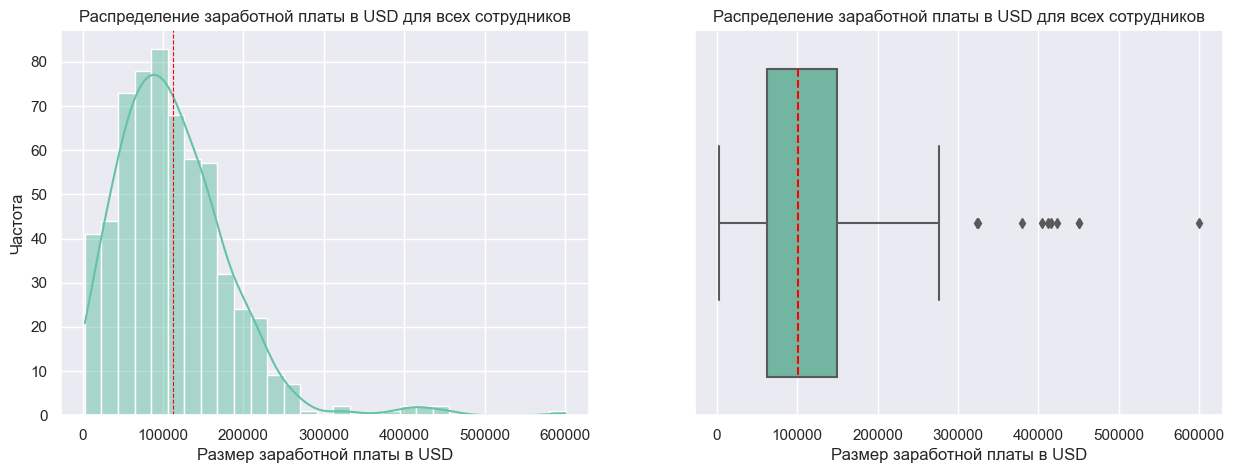

In [35]:
# строим гистограмму распределения заработной платы в USD и одновременно boxplot для большей наглядности
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data, x='salary_in_usd', kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы в USD', ylabel='Частота')
axes[0].set_title('Распределение заработной платы в USD для всех сотрудников')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data, x='salary_in_usd', ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Размер заработной платы в USD')
axes[1].set_title('Распределение заработной платы в USD для всех сотрудников')

plt.show()

Распределение заработной платы в USD отлично от нормального, имеются выбросы. Наличие выбросов подсказывает нам, что для изучения лучше использовать медиану (median), а не среднее (mean), поскольку медиана менее чувствительна к выбросам.

### Диаграммы для категориальных признаков

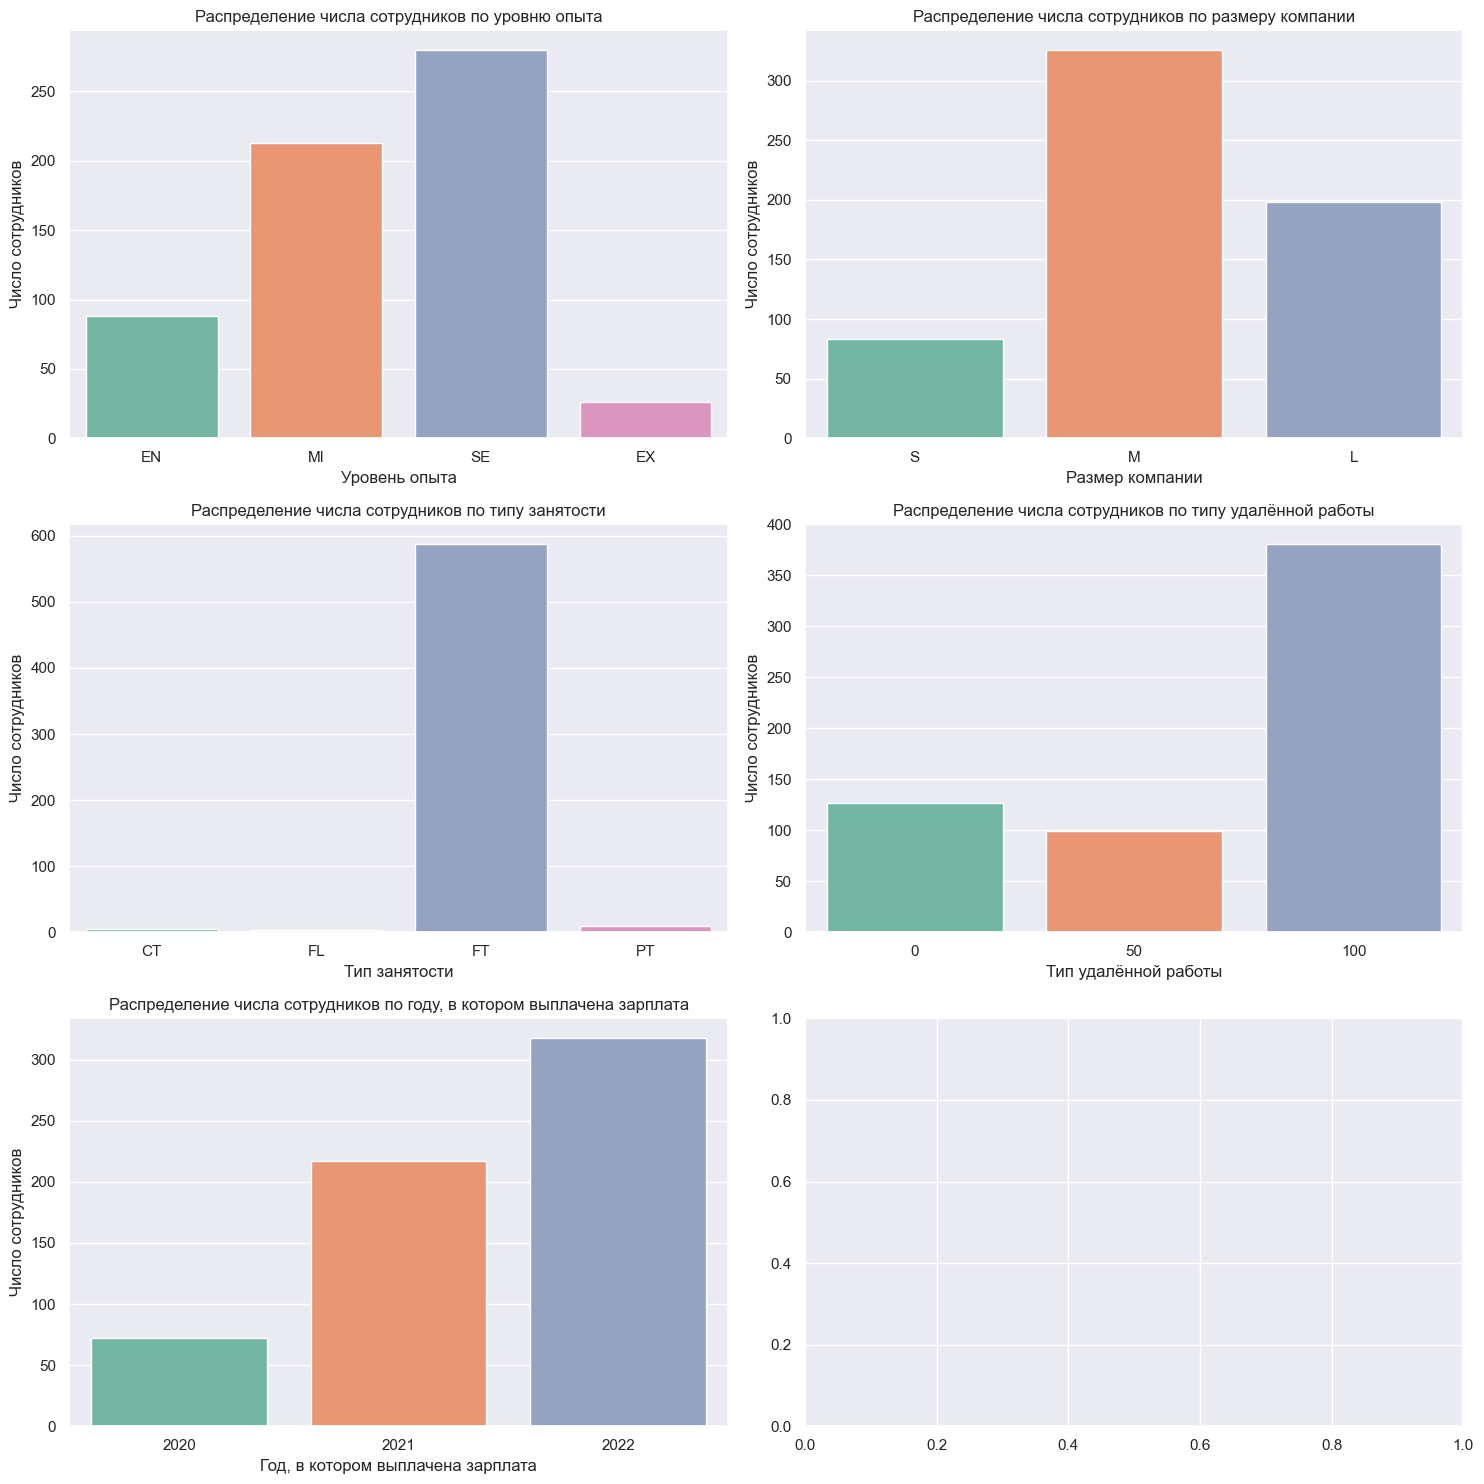

In [ ]:
# строим диаграммы распределения по уровню опыта, размеру компании, типу занятости, типу удалённой работы, году
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

sns.countplot(data, x='experience_level', ax=axes[0,0])
axes[0,0].set(xlabel='Уровень опыта', ylabel='Число сотрудников')
axes[0,0].set_title('Распределение числа сотрудников по уровню опыта')

sns.countplot(data, x='company_size', ax=axes[0,1])
axes[0,1].set(xlabel='Размер компании', ylabel='Число сотрудников')
axes[0,1].set_title('Распределение числа сотрудников по размеру компании')

sns.countplot(data, x='employment_type', ax=axes[1,0])
axes[1,0].set(xlabel='Тип занятости', ylabel='Число сотрудников')
axes[1,0].set_title('Распределение числа сотрудников по типу занятости')

sns.countplot(data, x='remote_ratio', ax=axes[1,1])
axes[1,1].set(xlabel='Тип удалённой работы', ylabel='Число сотрудников')
axes[1,1].set_title('Распределение числа сотрудников по типу удалённой работы')

sns.countplot(data, x='work_year', ax=axes[2,0])
axes[2,0].set(xlabel='Год, в котором выплачена зарплата', ylabel='Число сотрудников')
axes[2,0].set_title('Распределение числа сотрудников по году, в котором выплачена зарплата')

plt.tight_layout()
plt.show()

Чтобы построить распределение вакансий по оставшимся признакам (название роли, страна проживания сотрудника, страна регистрации компании), применим приём с выделением top 10 категорий (в противном случае из-за большого разнообразия значений мы получим длинный "хвост", который будет неудобен для анализа).

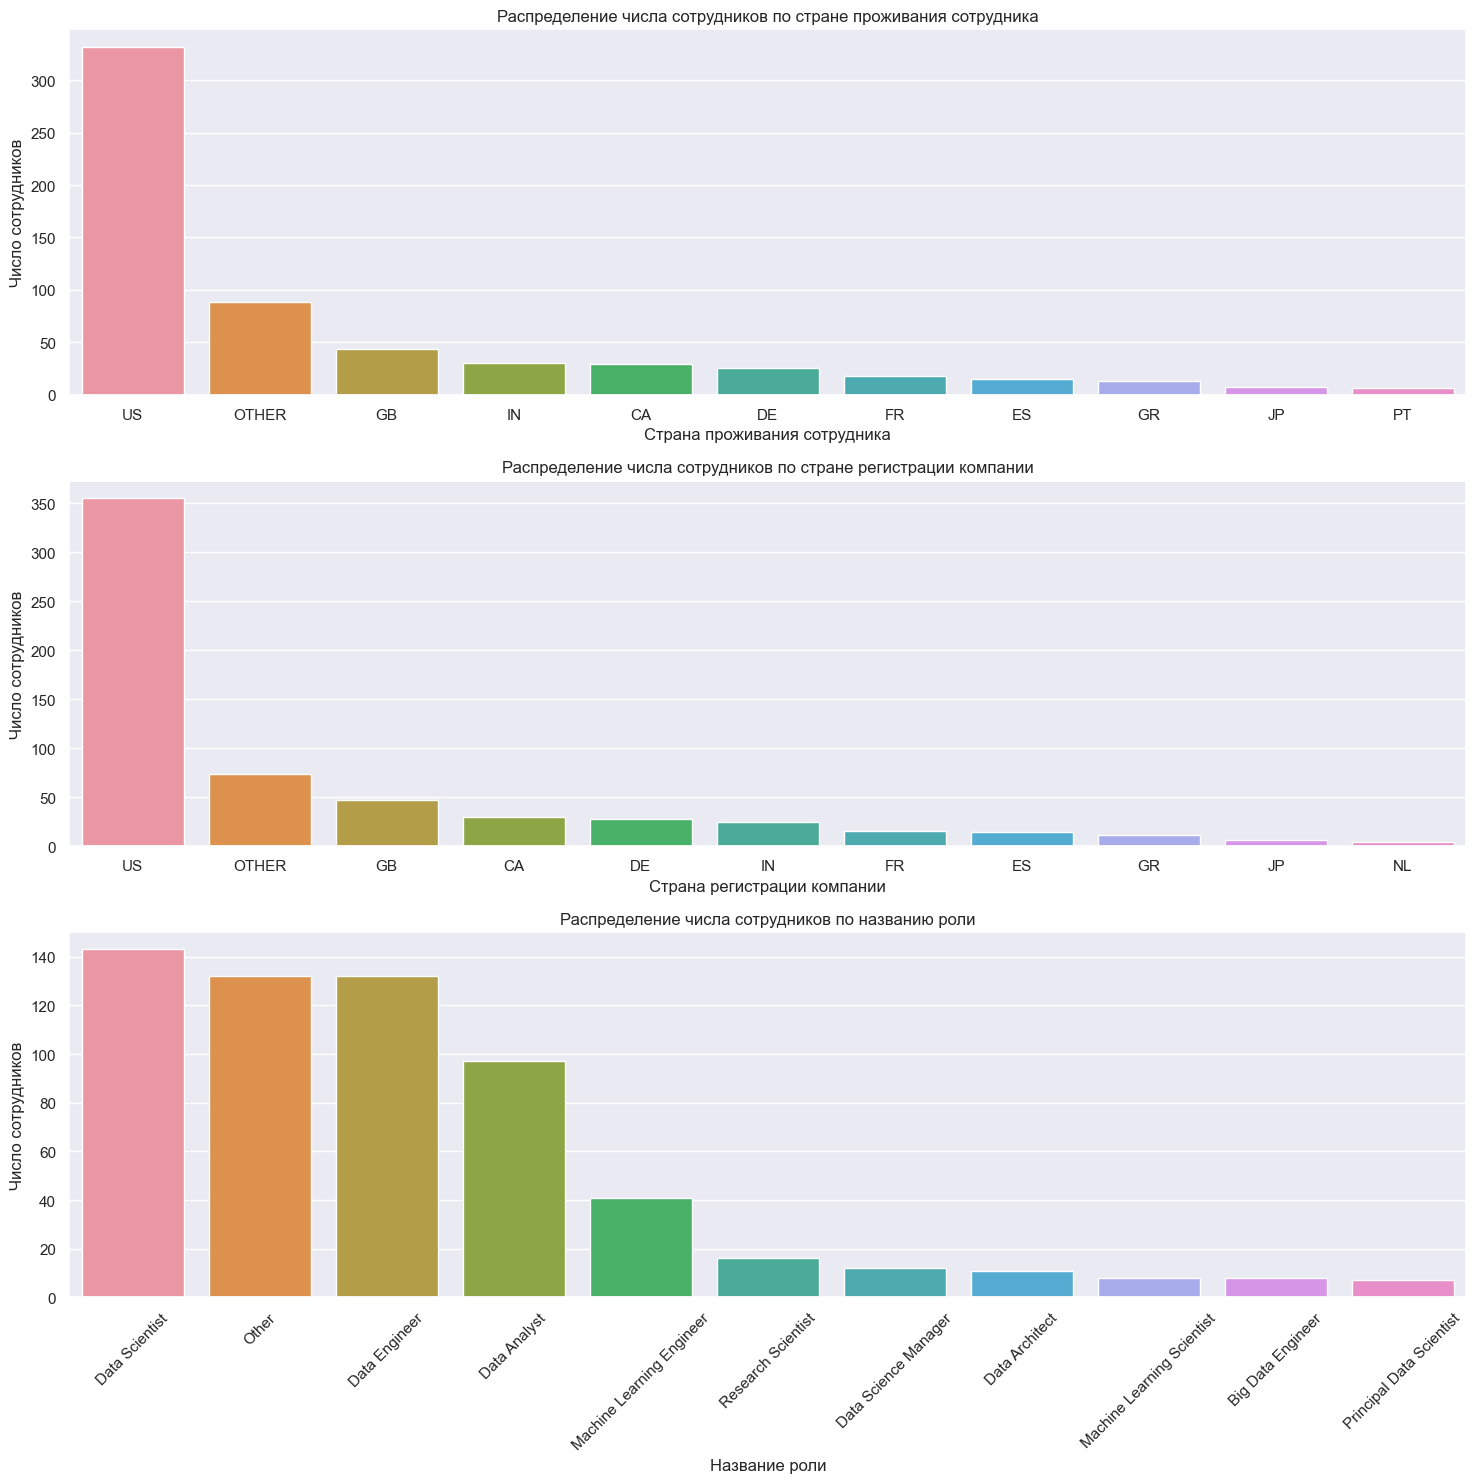

In [48]:
# подсчитываем значения в каждом поле
count_employee_residence = data['employee_residence'].value_counts()
count_company_location = data['company_location'].value_counts()
count_job_title = data['job_title'].value_counts()

# выделяем top 10
top_10_employee_residences = count_employee_residence.nlargest(10).index
top_10_company_locations = count_company_location.nlargest(10).index
top_10_job_titles = count_job_title.nlargest(10).index

# в остальных записях заменяем страну / название роли на Other
data['employee_residence_top_10'] = data['employee_residence'].apply(lambda x: x if x in top_10_employee_residences else 'OTHER')
data['company_location_top_10'] = data['company_location'].apply(lambda x: x if x in top_10_company_locations else 'OTHER')
data['job_title_top_10'] = data['job_title'].apply(lambda x: x if x in top_10_job_titles else 'Other')

# строим диаграммы
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

sns.countplot(data, x='employee_residence_top_10', order=data['employee_residence_top_10'].value_counts().index, ax=axes[0])
axes[0].set(xlabel='Страна проживания сотрудника', ylabel='Число сотрудников')
axes[0].set_title('Распределение числа сотрудников по стране проживания сотрудника')

sns.countplot(data, x='company_location_top_10', order=data['company_location_top_10'].value_counts().index, ax=axes[1])
axes[1].set(xlabel='Страна регистрации компании', ylabel='Число сотрудников')
axes[1].set_title('Распределение числа сотрудников по стране регистрации компании')

sns.countplot(data, x='job_title_top_10', order=data['job_title_top_10'].value_counts().index, ax=axes[2])
axes[2].set(xlabel='Название роли', ylabel='Число сотрудников')
axes[2].set_title('Распределение числа сотрудников по названию роли')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Оценка влияния факторов на заработную плату

Для оценки влияния факторов на заработную плату построим коробочные диаграммы, отображающие распределение заработной платы в USD для каждой категории.

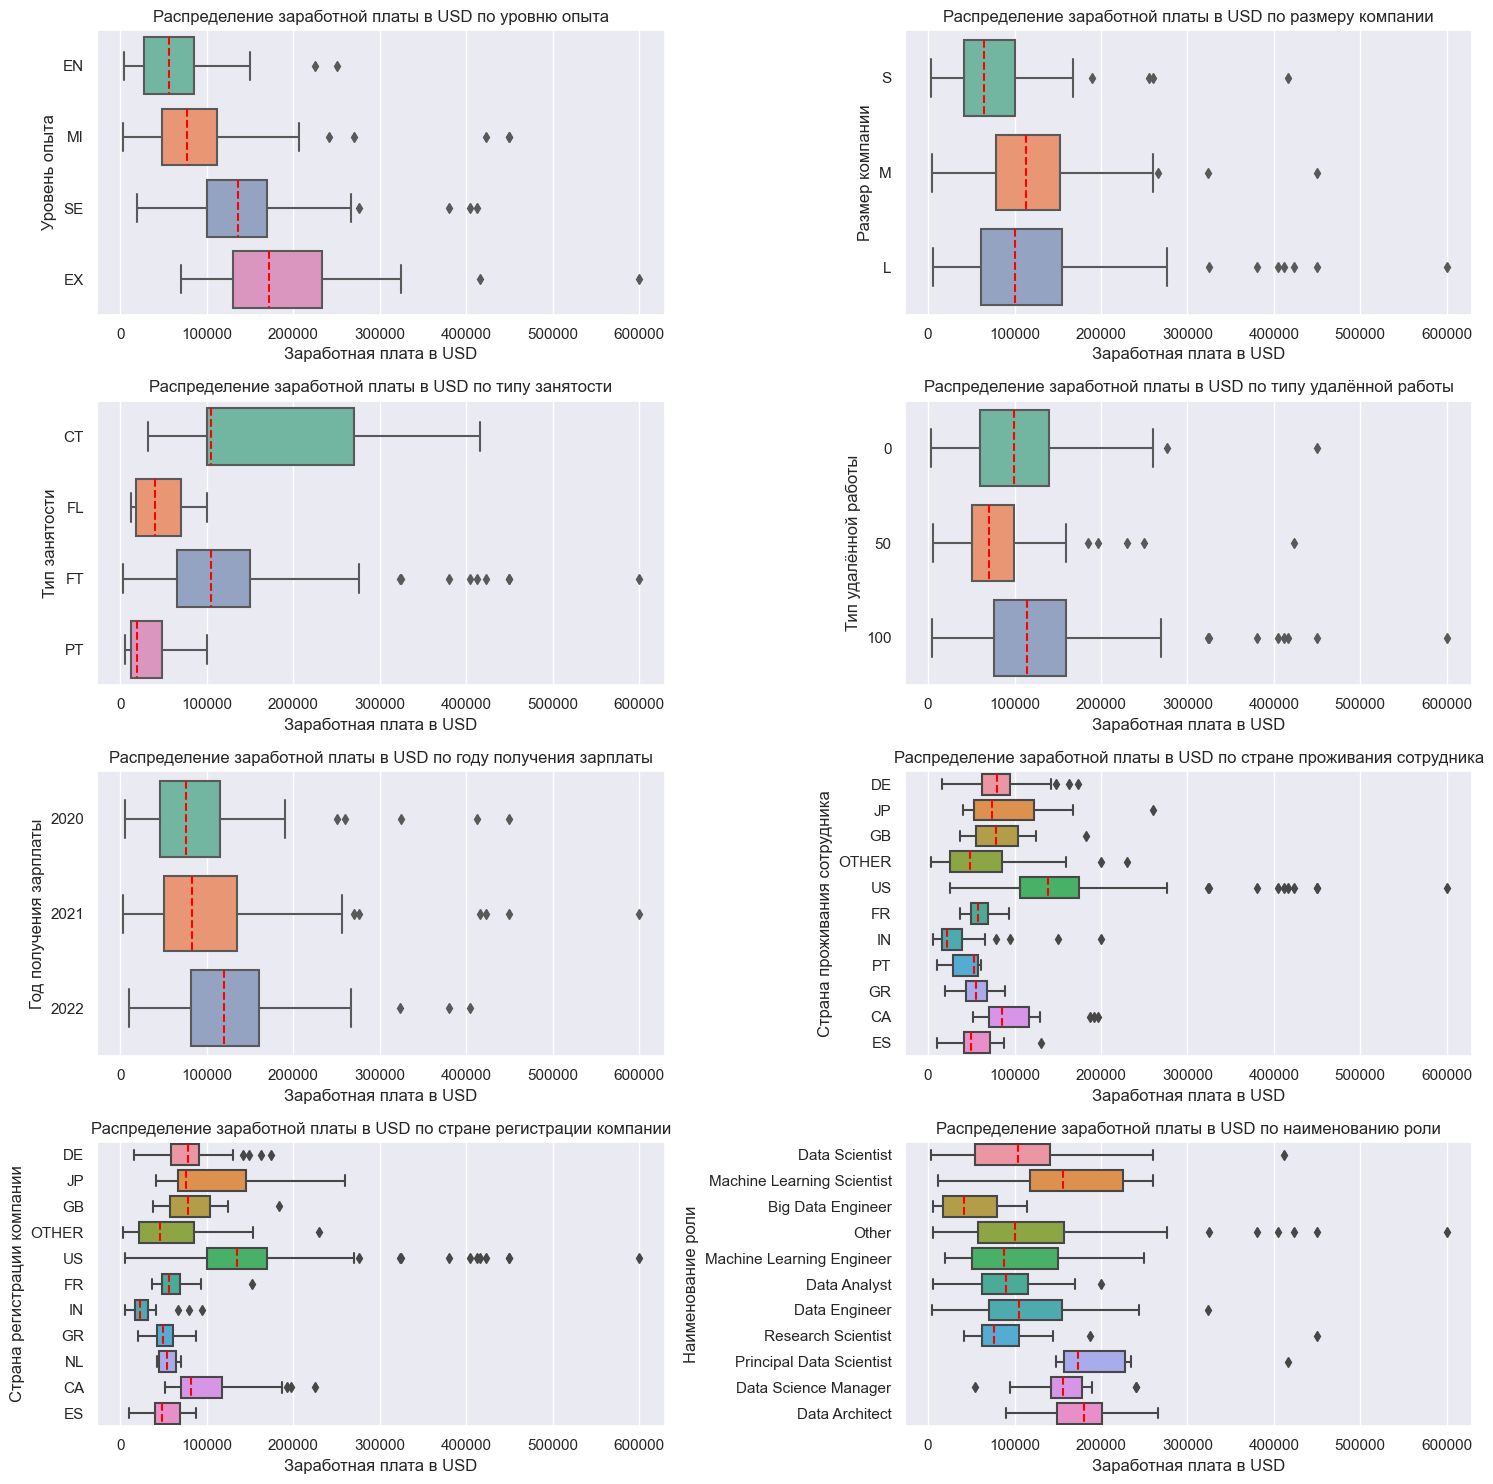

In [49]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0,0])
axes[0,0].set(xlabel='Заработная плата в USD', ylabel='Уровень опыта')
axes[0,0].set_title('Распределение заработной платы в USD по уровню опыта')

sns.boxplot(data, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0,1])
axes[0,1].set(xlabel='Заработная плата в USD', ylabel='Размер компании')
axes[0,1].set_title('Распределение заработной платы в USD по размеру компании')

sns.boxplot(data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1,0])
axes[1,0].set(xlabel='Заработная плата в USD', ylabel='Тип занятости')
axes[1,0].set_title('Распределение заработной платы в USD по типу занятости')

sns.boxplot(data, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1,1])
axes[1,1].set(xlabel='Заработная плата в USD', ylabel='Тип удалённой работы')
axes[1,1].set_title('Распределение заработной платы в USD по типу удалённой работы')

sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[2,0])
axes[2,0].set(xlabel='Заработная плата в USD', ylabel='Год получения зарплаты')
axes[2,0].set_title('Распределение заработной платы в USD по году получения зарплаты')

sns.boxplot(data, x='salary_in_usd', y='employee_residence_top_10', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[2,1])
axes[2,1].set(xlabel='Заработная плата в USD', ylabel='Страна проживания сотрудника')
axes[2,1].set_title('Распределение заработной платы в USD по стране проживания сотрудника')

sns.boxplot(data, x='salary_in_usd', y='company_location_top_10', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[3,0])
axes[3,0].set(xlabel='Заработная плата в USD', ylabel='Страна регистрации компании')
axes[3,0].set_title('Распределение заработной платы в USD по стране регистрации компании')

sns.boxplot(data, x='salary_in_usd', y='job_title_top_10', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[3,1])
axes[3,1].set(xlabel='Заработная плата в USD', ylabel='Наименование роли')
axes[3,1].set_title('Распределение заработной платы в USD по наименованию роли')

plt.tight_layout()
plt.show()

### Предварительные ответы на вопросы исследования

    *   Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    *   Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    *   Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    *   Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [42]:
data_year_ds = data[data['job_title']=='Data Scientist'].groupby(by='work_year', observed=False, as_index=False)['salary_in_usd'].median()
data_year_ds.columns = ['work_year', 'mean_salary']
data_year_ds

,work_year,mean_salary
0,2020,62726.0
1,2021,73000.0
2,2022,140000.0


In [41]:
data_2022 = data[(data['work_year']==2022)&((data['job_title']=='Data Scientist')|(data['job_title']=='Data Engineer'))].groupby(by='job_title', observed=False, as_index=False)['salary_in_usd'].median()
data_2022.columns = ['job_title', 'salary_in_usd']
data_2022

,job_title,salary_in_usd
0,Data Engineer,120000.0
1,Data Scientist,140000.0


In [40]:
data_size = data[data['job_title']=='Data Scientist'].groupby(by='company_size', observed=False, as_index=False)['salary_in_usd'].median()
data_size.sort_values(by='company_size', inplace=True)
data_size.reset_index(drop=True, inplace=True)
data_size.columns = ['company_size', 'salary_in_usd']
data_size

,company_size,salary_in_usd
0,S,49268.0
1,M,130000.0
2,L,90734.0


## Статистический анализ данных

## Итоговые результаты исследования